In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits
import scipy.ndimage
from astropy import units as u
import numpy as np

from scalessim.io import *
from scalessim.focal_plane import *
from scalessim.targs import *
from scalessim.base import *
from scalessim.detectors import *
from scalessim.widgets import *
from scalessim.psfs import *
from scalessim.scales import *


%load_ext autoreload
%autoreload 2

/Users/stephsallum/Sallum Group Dropbox/Steph Sallum/scalessim_github/scalessim/scalessim/detector/nghxrg.py:345: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if mode is 'pink':


In [35]:
nexps = 50 #number of exposures (set to match number of PAs...)
tint = 100 #integration time per exposure
PAs = np.linspace(-80.,80,nexps) #parallactic angles in deg
T_p = 900.0 #planet temperature in K
s_p = 500.0 #planet separation in mas
d = 10.0 #system distance in pc
T_s = 3800.0 #stellar temperature in K
PA_p = 45.0 #planet PA 
vapors_all = 1.0
airmass = np.linspace(2,1,nexps//2)
airmass_all = np.array(list(airmass)+list(airmass)[::-1])

# configure SCALES

In [20]:
scalesmode = mode_select(start=0)
scalesmode

Dropdown(description='Mode:', options=('Low-Res SED: 2.0-5.2', 'Low-Res K: 1.95-2.45', 'Med-Res K: 1.95-2.45',…

In [21]:
sim = SCALES(scalesmode,verbose=True)

In [22]:
vapor = 1.0 #PWV in mm
airmass = 1.0
inst_emissivities = [0.4]
inst_temps = [277*u.K]

sim.skybg = SkyBG(vapor,airmass)
sim.skytrans = SkyTrans(vapor,airmass)
sim.atmodisp = AtmoDispersion(90,20,600)

sim.inst = InstTransEm(inst_emissivities, inst_temps)
sim.qe = QE()
#dit = 1 ###integration time in seconds


sim.args = {'Lenslet_object':sim.lens,
            'SkyBG':sim.skybg,
            'SkyTrans':sim.skytrans,
            'InstTransEm':sim.inst,
            'Filter':sim.filt,
            'QE':sim.qe}

# set up PSFs

In [23]:
guidestar = gs_select()
guidestar

Dropdown(description='GS Mag:', options=(5, 12, 13, 14), value=5)

In [24]:
PSF = PSFs(guidestar,sim)
psfs, psfs_coron = PSF.PSF_sequence(nframes=nexps, vortex=True)
print(psfs.shape)

False
(50, 341, 108, 108)


# make planet scene

## without coronagraph

In [25]:
scene, scene_conv = planet_ADI_scene_lowres(psfs,
                     T_s=T_s,
                     T_p=T_p,
                     d=d,
                     p_sep=s_p, p_PA=PA_p,
                     PAlist = PAs,vortex=False)

## with coronagraph

In [26]:
scene_c, scene_conv_c, scene_conv_s = planet_ADI_scene_lowres(psfs,
                                                              T_s=T_s,
                                                              T_p=T_p,
                                                              d=d,
                                                              p_sep=s_p, p_PA=PA_p,
                                                              PAlist = PAs,vortex=True,
                                                              psfs_coron=psfs_coron)

## make a scene for sky subtraction

In [27]:
scene_sky = np.zeros(scene_conv_c.shape)*u.erg/u.cm/u.cm/u.s/u.um

# generate SCALESSIM cubes

In [34]:
cube_star,lams_star = sim.cube(cube_in=scene_conv_s,verbose=True,dit=tint,vapor=vapors_all,airmass=airmass_all)

Label(value='Progress: 0 of 50 images')

IntProgress(value=0, max=50)

0 1.0 <class 'numpy.ndarray'> 2.0
1 1.0 <class 'numpy.ndarray'> 1.9583333333333333
2 1.0 <class 'numpy.ndarray'> 1.9166666666666667
3 1.0 <class 'numpy.ndarray'> 1.875
4 1.0 <class 'numpy.ndarray'> 1.8333333333333333
5 1.0 <class 'numpy.ndarray'> 1.7916666666666667
6 1.0 <class 'numpy.ndarray'> 1.75
7 1.0 <class 'numpy.ndarray'> 1.7083333333333335
8 1.0 <class 'numpy.ndarray'> 1.6666666666666667
9 1.0 <class 'numpy.ndarray'> 1.625
10 1.0 <class 'numpy.ndarray'> 1.5833333333333335
11 1.0 <class 'numpy.ndarray'> 1.5416666666666667
12 1.0 <class 'numpy.ndarray'> 1.5
13 1.0 <class 'numpy.ndarray'> 1.4583333333333335
14 1.0 <class 'numpy.ndarray'> 1.4166666666666667
15 1.0 <class 'numpy.ndarray'> 1.375
16 1.0 <class 'numpy.ndarray'> 1.3333333333333335
17 1.0 <class 'numpy.ndarray'> 1.2916666666666667
18 1.0 <class 'numpy.ndarray'> 1.25
19 1.0 <class 'numpy.ndarray'> 1.2083333333333335
20 1.0 <class 'numpy.ndarray'> 1.1666666666666667
21 1.0 <class 'numpy.ndarray'> 1.125
22 1.0 <class 'numpy

In [12]:
cube_coron, lams_coron = sim.cube(cube_in=scene_conv_c,verbose=True,dit=tint)

Label(value='Progress: 0 of 50 images')

IntProgress(value=0, max=50)

binning down oversampled cube


In [13]:
cube_sky, lams_sky = sim.cube(cube_in=scene_sky,verbose=True,dit=tint)

Label(value='Progress: 0 of 50 images')

IntProgress(value=0, max=50)

binning down oversampled cube


In [14]:
sky_sub = np.mean(cube_sky,axis=0)

In [15]:
cube_skysub_coron = cube_coron[:]-sky_sub
cube_skysub_A = cube_star[:]-sky_sub

# process with vip : ADI on individual wavelengths

In [16]:
import vip_hci as vip
from vip_hci.psfsub import pca
from vip_hci.metrics import snrmap

## full frame PCA with small number of components

In [17]:
pca_cube = np.zeros((54,108,108))
pca_cubeA = np.zeros((54,108,108))
snr_cube = np.zeros((54,108,108))
for ii in range(54):
    pca_cube[ii] = pca(cube_skysub_coron[:,ii], PAs, ncomp=2, delta_rot = 5, mask_center_px=0)
    snr_cube[ii] = snrmap(pca_cube[ii], 4, approximated=True,plot=False)
    pca_cubeA[ii] = pca(cube_skysub_A[:,ii], PAs, ncomp=2, delta_rot = 5, mask_center_px=0)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-06-17 19:09:30
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 137.439 GB
System available memory = 78.515 GB
Done vectorizing the frames. Matrix shape: (50, 11664)
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.036381
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Done de-rotating and combining
Running time:  0:00:00.909472
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-06-17 19:09:30
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
S/N map created using 8 processes
Running time:  0:00:00.161978
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
―――――――――――――――――――――――――――――――――――――――――――――――

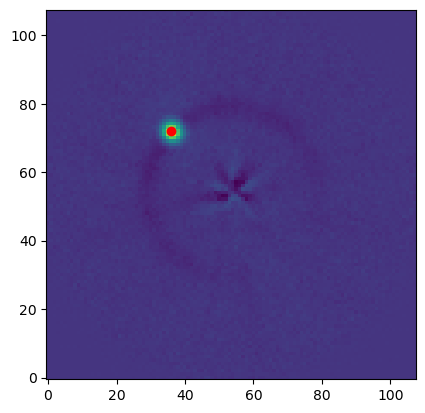

In [18]:
plt.imshow(np.sum(pca_cube,axis=0),origin='lower')
plt.scatter(36,72,c='r')
plt.show()

## optimize number of principle components: example for single wavelength

In [19]:
posn = (36,72)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-06-17 19:11:14
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
System total memory = 137.439 GB
System available memory = 78.281 GB
Done SVD/PCA with numpy SVD (LAPACK)
Running time:  0:00:00.011220
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Number of steps 25
Optimal number of PCs = 3, for S/N=16.666
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Coords of chosen px (X,Y) = 36.0, 72.0
Flux in a centered 1xFWHM circular aperture = 6938.423
Central pixel S/N = 19.296
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Inside a centered 1xFWHM circular aperture:
Mean S/N (shifting the aperture center) = 16.666
Max S/N (shifting the aperture center) = 26.260
stddev S/N (shifting the aperture center) = 6.140



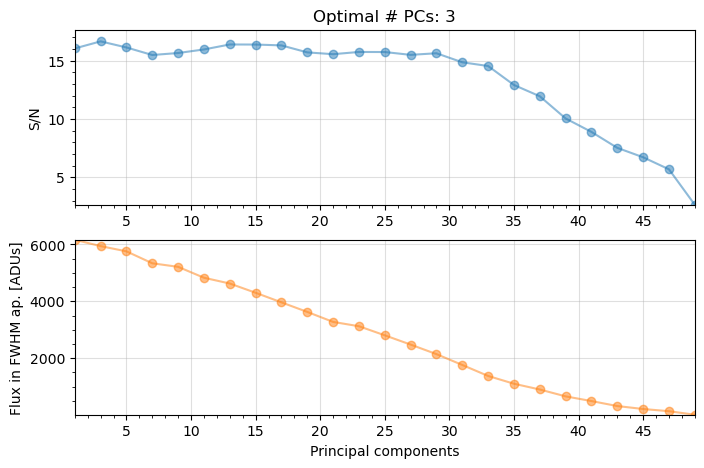

In [20]:
fr_pca_sing = pca(cube_skysub_coron[:,27], PAs, fwhm=3, source_xy=posn, 
                       mask_center_px=None, ncomp=(1, 61, 2))

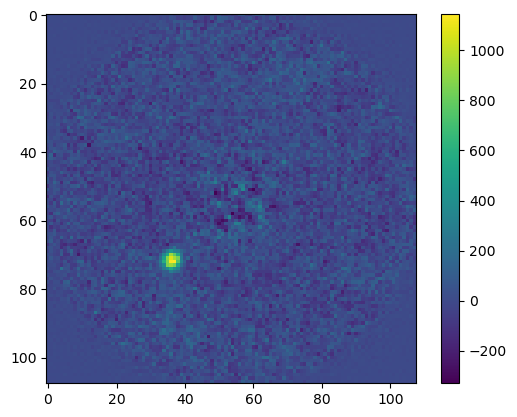

In [21]:
plt.imshow(fr_pca_sing)
plt.colorbar()
plt.show()

In [23]:
from vip_hci.fm import firstguess

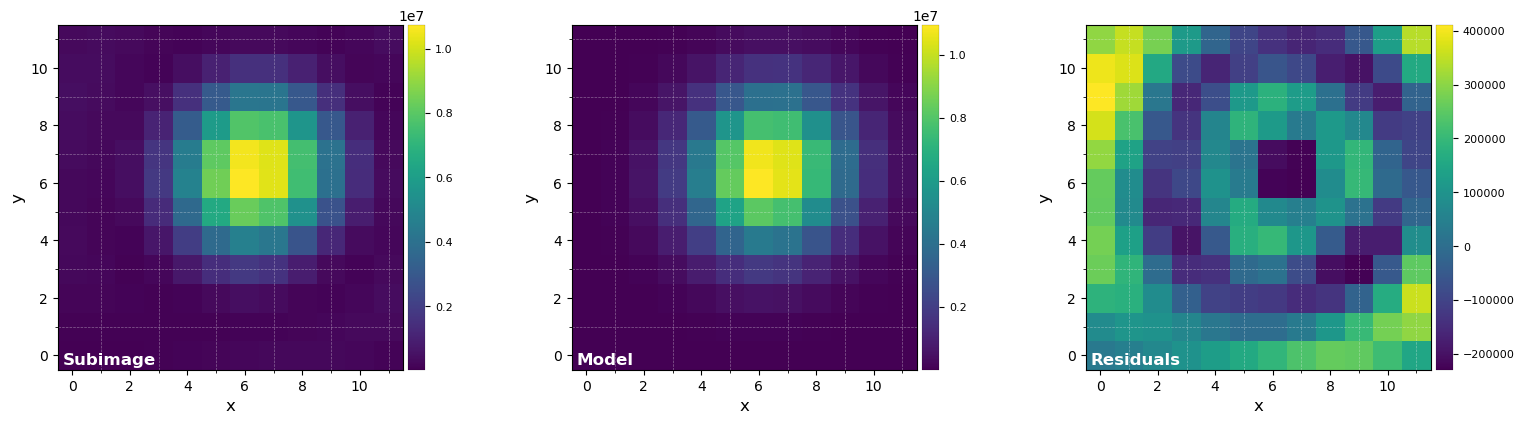

FWHM_y = 4.120656329356284
FWHM_x = 4.32422259152405 

centroid y = 54.452183965746805
centroid x = 54.3841843058451
centroid y subim = 6.452183965746808
centroid x subim = 6.384184305845106 

amplitude = 11546672.551271334
theta = -312.772884966358


In [24]:
_ = vip.var.fit_2dgaussian(np.median(cube_skysub_A[:,27],axis=0), crop=True, cropsize=12, debug=True)
####this is just the stellar PSF (calibrated_cubeA)

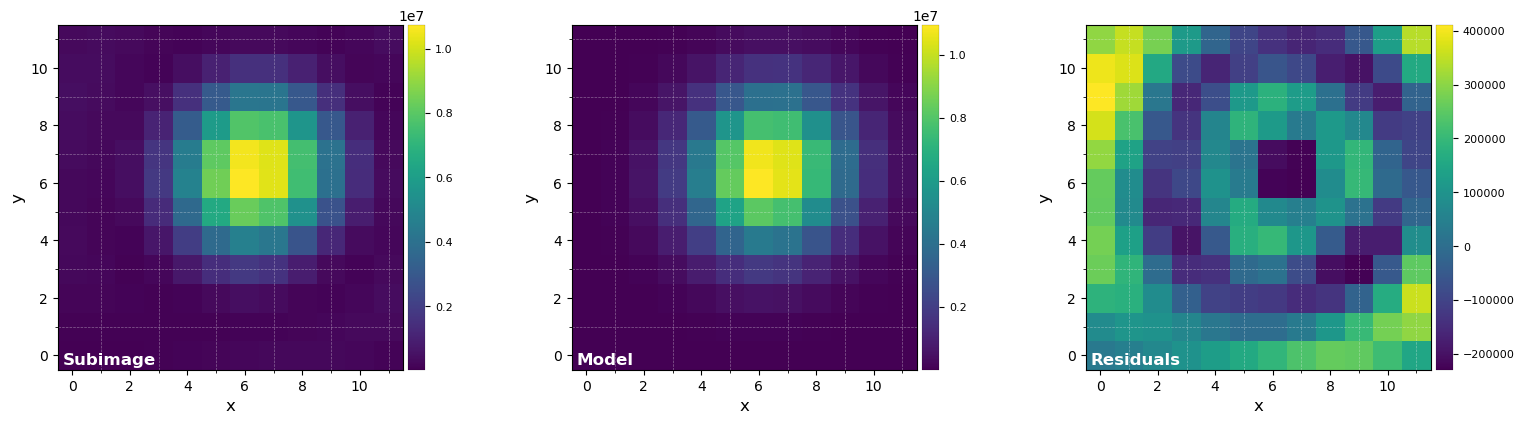

FWHM_y = 4.120656329356284
FWHM_x = 4.32422259152405 

centroid y = 54.452183965746805
centroid x = 54.3841843058451
centroid y subim = 6.452183965746808
centroid x subim = 6.384184305845106 

amplitude = 11546672.551271334
theta = -312.772884966358
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Starting time: 2025-06-17 19:20:57
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
             Planet 0           
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――

Planet 0: flux estimation at the position [36,72], running ...
Step | flux    | chi2r
1/50   20.000   0.215
2/50   121.633   0.216
3/50   223.265   0.216
4/50   324.898   0.217


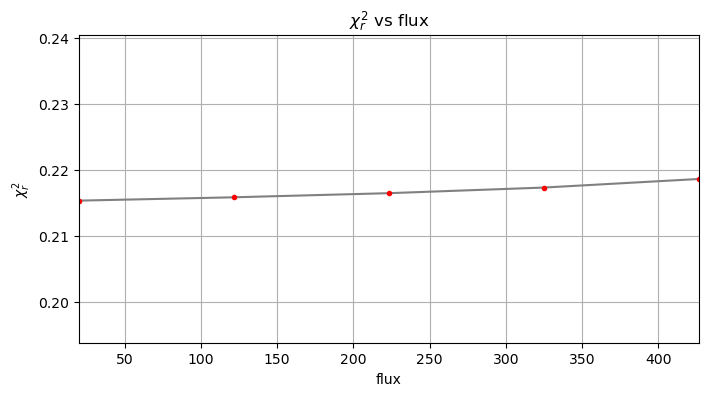

Planet 0: preliminary position guess: (r, theta)=(25.5, 135.0)
Planet 0: preliminary flux guess: 20.00
Planet 0: Simplex Nelder-Mead minimization skipped.
Planet 0 simplex result: (r, theta, f)=(25.456, 135.000, 20.000) at 
          (X,Y)=(36.00, 72.00)

 ―――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――― 
DONE !
 ――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
Running time:  0:00:01.335191
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――


In [25]:
fit = vip.var.fit_2dgaussian(np.median(cube_skysub_A[:,27],axis=0), crop=True, cropsize=12, debug=True)
fwhm=0.5*(fit['fwhm_y'][0]+fit['fwhm_x'][0])
psfn, flux_fwhm, _ = vip.fm.normalize_psf(np.median(cube_skysub_A[:,27],axis=0), fwhm, size=19, full_output=True,verbose=False)
    
#informed = np.linspace((flux_fwhm*dspec[ii] / Aspec[ii]-100)[0], (flux_fwhm*dspec[ii] / Aspec[ii]+100)[0], 20)
r_0, theta_0, f_0 = vip.fm.firstguess(cube_skysub_coron[:,27], PAs, psfn, ncomp=27,
                               planets_xy_coord=[posn], fwhm=fwhm, 
                               f_range=np.linspace(20,5000,50), annulus_width=4*fwhm, aperture_radius=2,
                               simplex=False, plot=True, verbose=True)


